<a href="https://colab.research.google.com/github/azrizalg/azrizalg/blob/main/Covid_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from google.colab import files
from google.colab import drive
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

     |████████████████████████████████| 1.5MB 6.2MB/s 
     |████████████████████████████████| 9.5MB 16.6MB/s 
     |████████████████████████████████| 2.1MB 30.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
# Import the models we'll be using in this section
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

# Authorization

# Import Data

In [ ]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovery = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
url_dataLokasi = 'https://drive.google.com/uc?export=download&id=1oSPiGpmAW08DnYPk0xg03fDwdKZduZOF'

# Data Preprocessing

## Reform Data

In [ ]:
df_case = pd.read_csv(url_case)
df_death = pd.read_csv(url_death)
df_recovery = pd.read_csv(url_recovery)
df_dataLokasi = pd.read_csv(url_dataLokasi)

df_case = df_case.drop(['Province/State', 'Lat','Long'], axis=1)
df_case = df_case.groupby(['Country/Region']).sum() #karena terdapat region yang double
df_case = df_case.transpose().reset_index()
df_case = pd.melt(df_case,id_vars=['index'])
df_case.rename(columns={'value': 'total_cases'}, inplace=True)

df_death = df_death.drop(['Province/State', 'Lat','Long'], axis=1)
df_death = df_death.groupby(['Country/Region']).sum()
df_death = df_death.transpose().reset_index()
df_death = pd.melt(df_death,id_vars=['index'])
df_death.rename(columns={'value': 'total_deaths'}, inplace=True)#inplace = dataframe di replace langsung

df_recovery = df_recovery.drop(['Province/State', 'Lat','Long'], axis=1)
df_recovery = df_recovery.groupby(['Country/Region']).sum()
df_recovery = df_recovery.transpose().reset_index()
df_recovery = pd.melt(df_recovery,id_vars=['index'])
df_recovery.rename(columns={'value': 'total_recoveries'}, inplace=True)

#merge ketiga dataframe diatas menjadi satu
df = pd.merge(df_case, df_death, on=['index','Country/Region'])
df = pd.merge(df, df_recovery, on=['index','Country/Region'])

df.rename(columns={'index': 'tanggal'}, inplace=True)
df['tanggal'] = pd.to_datetime(df['tanggal'])#ubah format kolom tanggal dari obj ke datetime

df.dtypes



tanggal             datetime64[ns]
Country/Region              object
total_cases                  int64
total_deaths                 int64
total_recoveries             int64
dtype: object

## Menyiapkan data

In [ ]:
dataset = df[['tanggal','total_cases','total_deaths', 'total_recoveries']]
dataset = dataset.groupby(['tanggal'])[['total_cases','total_deaths','total_recoveries']].sum().reset_index()# digabung berdasarkan tanggalnya

#--penambahan Kolom---
#kasus
dataset['new_cases'] = dataset['total_cases'] - dataset['total_cases'].shift(+1, fill_value=0)#memasukkan selisih kasus dengan hari sebelumnya

#kematian
dataset['new_deaths'] = dataset['total_deaths'] - dataset['total_deaths'].shift(+1, fill_value=0)#memasukkan selisih kasus dengan hari sebelumnya

#kesembuhan
dataset['new_recoveries'] = dataset['total_recoveries'] - dataset['total_recoveries'].shift(+1, fill_value=0)#memasukkan selisih kasus dengan hari sebelumnya



### Konversi `tanggal` menjadi format yang sesuai dan jadikan index dari dataset

In [ ]:
dataset['tanggal'] = pd.to_datetime(dataset['tanggal'])
dataset.set_index(['tanggal'], inplace=True)
dataset = dataset.asfreq(freq='D')
dataset.head()

,total_cases,total_deaths,total_recoveries,new_cases,new_deaths,new_recoveries
tanggal,,,,,,
2020-01-22,557,17,30,557,17,30
2020-01-23,655,18,32,98,1,2
2020-01-24,941,26,39,286,8,7
2020-01-25,1433,42,42,492,16,3
2020-01-26,2118,56,56,685,14,14


## Separasi

In [ ]:
datasetCase = dataset['new_cases']
datasetTotalCase = dataset['total_cases']
datasetDeath = dataset['new_deaths']

# Eda

## Moving Average

In [ ]:
datasetCaseMA = datasetCase.rolling(window=7).mean()

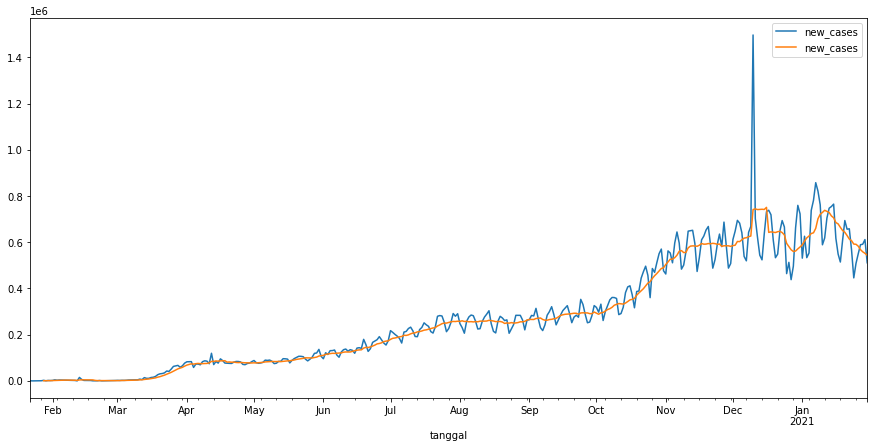

In [ ]:
pd.concat([datasetCase, datasetCaseMA], axis=1).plot(figsize=(15, 7))

## Holter prescott

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [ ]:
caseCycle, caseTrend = hpfilter(datasetCase, lamb=14400)

In [ ]:
pd.concat([caseCycle, caseTrend], axis=1)

,new_cases,new_cases
tanggal,,
2020-01-22,-489.720123,1046.720123
2020-01-23,-914.368036,1012.368036
2020-01-24,-691.981940,977.981940
2020-01-25,-451.464329,943.464329
2020-01-26,-223.669644,908.669644
...,...,...
2021-01-26,-44266.647733,594619.647733
2021-01-27,-1067.946751,590551.946751
2021-01-28,5045.305824,586474.694176


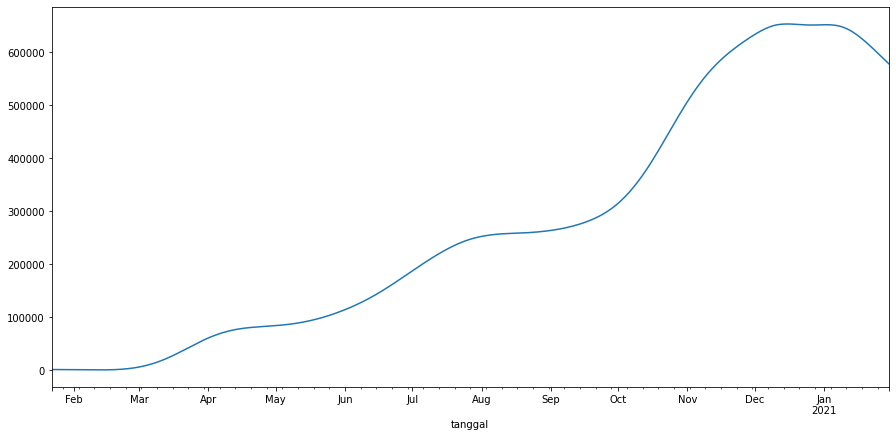

In [ ]:
caseTrend.plot(figsize=(15, 7))

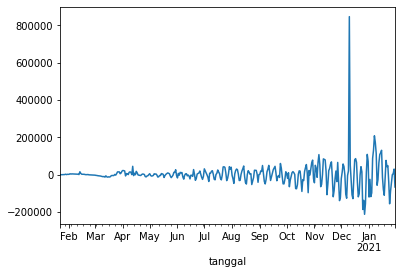

In [ ]:
caseCycle.plot()

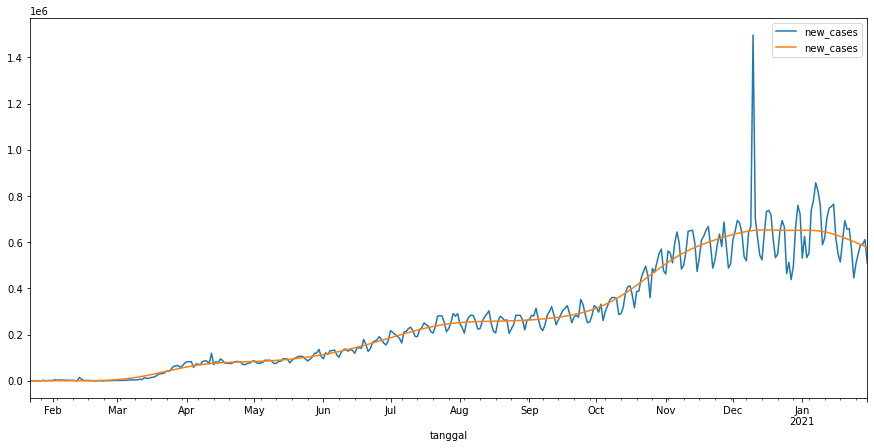

In [ ]:
pd.concat([datasetCase, caseTrend], axis=1).plot(figsize=(15, 7))

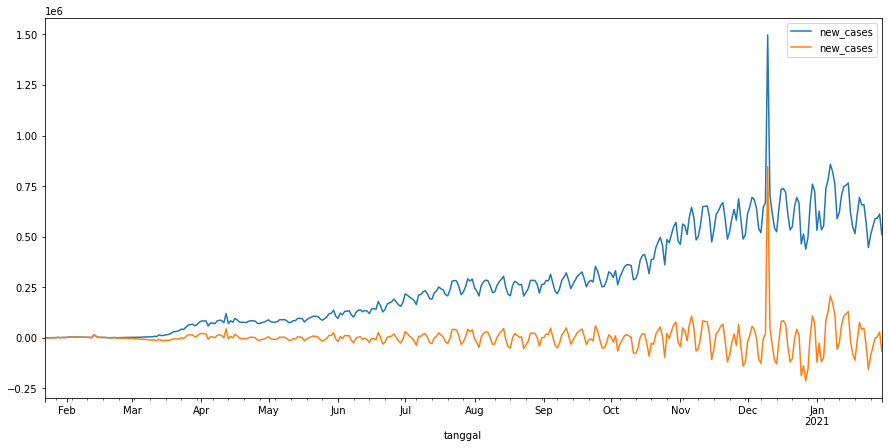

In [ ]:
pd.concat([datasetCase, caseCycle], axis=1).plot(figsize=(15, 7))

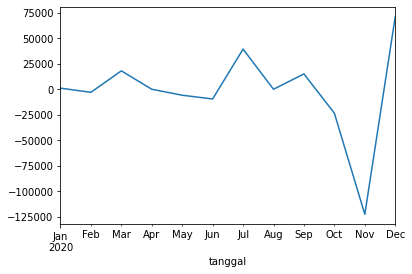

In [ ]:
caseCycle.asfreq(freq='M').plot()

## ETS decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(datasetCase, model = 'multiplicative')

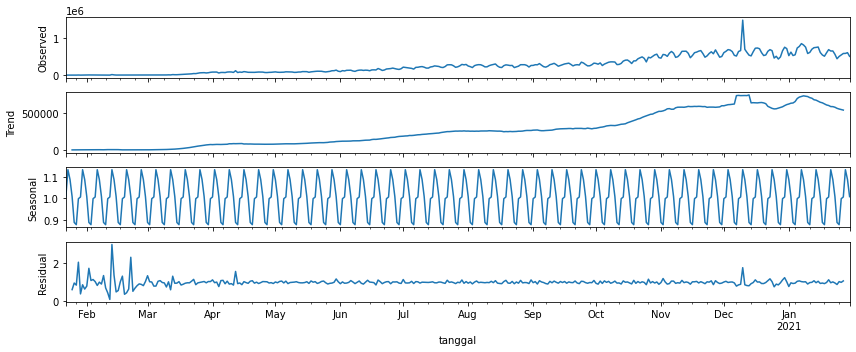

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5

result.plot();

In [ ]:
  result.trend

tanggal
2020-01-22              NaN
2020-01-23              NaN
2020-01-24              NaN
2020-01-25       796.857143
2020-01-26       801.428571
                  ...      
2021-01-26    552154.142857
2021-01-27    544137.142857
2021-01-28              NaN
2021-01-29              NaN
2021-01-30              NaN
Freq: D, Name: new_cases, Length: 375, dtype: float64

## ACF dan PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

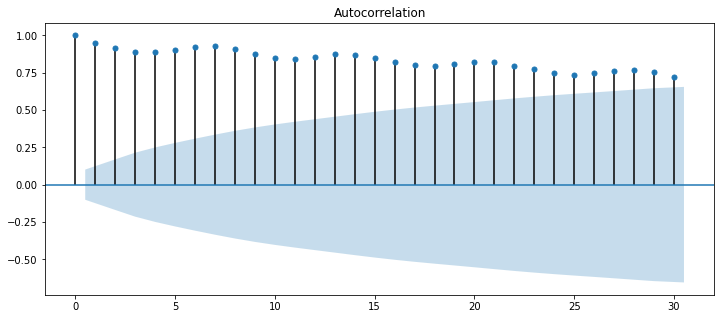

In [ ]:
plot_acf(datasetCase, lags = 30);

In [ ]:
datasetCase.expanding().sum()

tanggal
2020-01-22          557.0
2020-01-23          655.0
2020-01-24          941.0
2020-01-25         1433.0
2020-01-26         2118.0
                 ...     
2021-01-26    100276548.0
2021-01-27    100866032.0
2021-01-28    101457552.0
2021-01-29    102069223.0
2021-01-30    102580474.0
Freq: D, Name: new_cases, Length: 375, dtype: float64

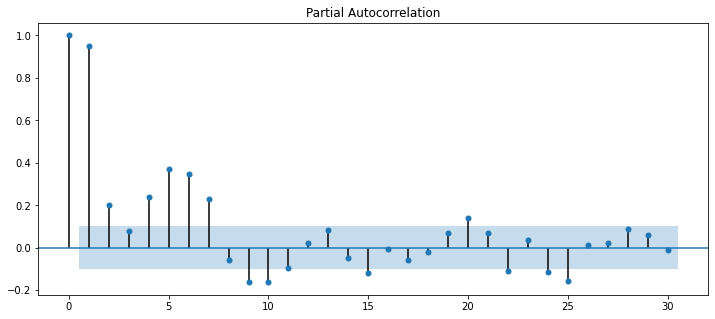

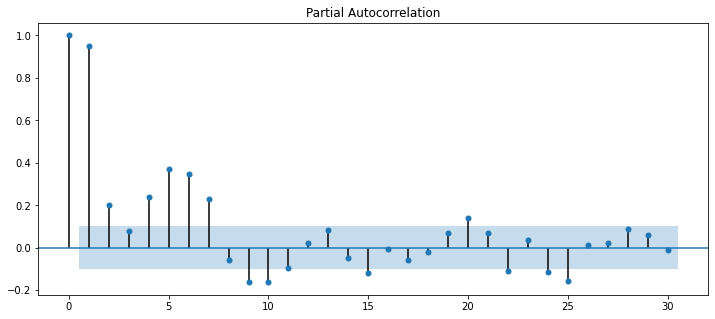

In [ ]:
plot_pacf(datasetCase, lags = 30)

# Descriptive statistics and test

## seasonality check

In [ ]:
from statsmodels.tsa.stattools import adfuller

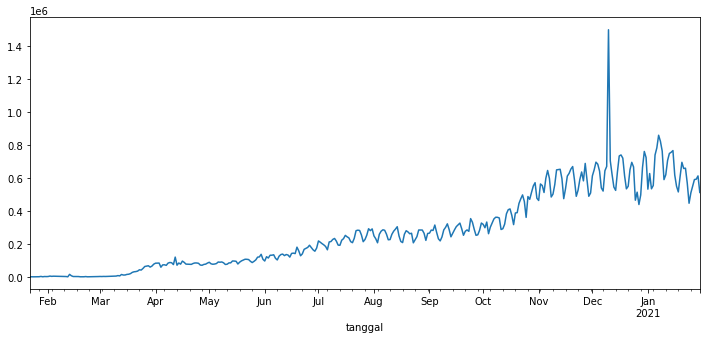

In [ ]:
datasetCase.plot()

In [ ]:
adfuller(datasetCase)

(-0.8265415666986309,
 0.8112011031186529,
 10,
 364,
 {'1%': -3.4484434475193777,
  '10%': -2.571017574266393,
  '5%': -2.869513170510808},
 8846.947294026455)

In [ ]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        data series
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression
    
        * 'c' : constant only (default)
        * 'ct' : constant and trend
        * 'ctt' : constant, and linear and quadratic trend
        * 'nc' : no constant, no trend
    autolag : {'AIC', 'BIC', 't-stat', None}
        * if None, then maxlag lags are used
        * if 'AIC' (default) or 'BIC', then the number of lags is chosen
          to minimize the corresponding information 

In [ ]:
dftest = adfuller(datasetCase)
dfout = pd.Series(dftest[:4], index=['ADF test statistics', 'p-value','# lags used', '# observations'])

In [ ]:
dfout

ADF test statistics     -0.826542
p-value                  0.811201
# lags used             10.000000
# observations         364.000000
dtype: float64

In [ ]:
for key, val in dftest[4].items(): # ngambil dictionary dari df test
  dfout[f'critical value ({key})'] = val

In [ ]:
dfout

ADF test statistics      -0.826542
p-value                   0.811201
# lags used              10.000000
# observations          364.000000
critical value (1%)      -3.448443
critical value (5%)      -2.869513
critical value (10%)     -2.571018
dtype: float64

### bikin fungsi adf test, sama seperti manual, cuma di bikin aga otomatis

In [ ]:
def adf_test(series, title=''):
  #masukin df time series dan judul(optional)
  
  print(f'Augmented Dickey-Fuller Test on {title}')
  result = adfuller(series.dropna(), autolag='AIC')#dropna handled differenced data
  
  labels = ['ADF test statistics', 'p-value','# lags used', '# observations']#nambahin label
  out = pd.Series(result[:4], index=labels)

  for key, val in result[4].items(): # ngambil dictionary dari df test
    out[f'critical value ({key})'] = val

  print(out.to_string())        #ngilangin tulisan dtype: float64
  if result[1] <= 0.05: #jika p-value <= 0.05 maka
      print("Strong evidence againt the null hypothesis")
      print("Reject the null hypothesis")
      print("Data has no unit root and is stationary")
  else:
      print("Weak evidence againt the null hypothesis")
      print("Fail to reject the null hypothesis")
      print("Data has unit root and is non-stationary")

In [ ]:
adf_test(datasetCase)

Augmented Dickey-Fuller Test on 
ADF test statistics      -0.826542
p-value                   0.811201
# lags used              10.000000
# observations          364.000000
critical value (1%)      -3.448443
critical value (5%)      -2.869513
critical value (10%)     -2.571018
Weak evidence againt the null hypothesis
Fail to reject the null hypothesis
Data has unit root and is non-stationary


# Causality = hubungan antara satu time series dengan time series lain

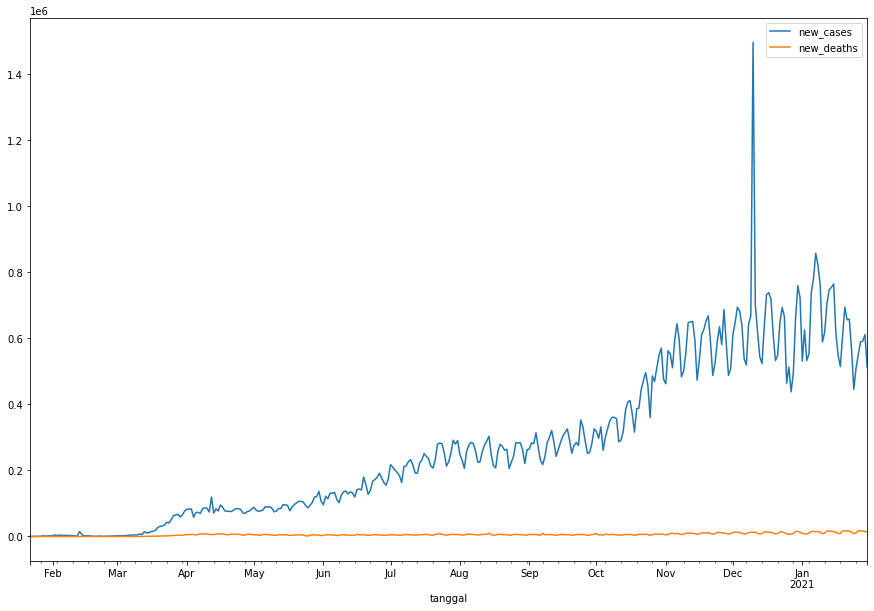

In [ ]:
dataset[['new_cases', 'new_deaths']].plot(figsize= (15,10))

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
grangercausalitytests(dataset[['total_cases','total_deaths']],5); #jika p kurang dari 0.05 maka ada causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=65.5403 , p=0.0000  , df_denom=371, df_num=1
ssr based chi2 test:   chi2=66.0703 , p=0.0000  , df=1
likelihood ratio test: chi2=60.8418 , p=0.0000  , df=1
parameter F test:         F=65.5403 , p=0.0000  , df_denom=371, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.9726  , p=0.0002  , df_denom=368, df_num=2
ssr based chi2 test:   chi2=18.1890 , p=0.0001  , df=2
likelihood ratio test: chi2=17.7594 , p=0.0001  , df=2
parameter F test:         F=8.9726  , p=0.0002  , df_denom=368, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.5518 , p=0.0000  , df_denom=365, df_num=3
ssr based chi2 test:   chi2=50.6076 , p=0.0000  , df=3
likelihood ratio test: chi2=47.4486 , p=0.0000  , df=3
parameter F test:         F=16.5518 , p=0.0000  , df_denom=365, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=18.4475 , p=0.0000  

In [ ]:
np.random.seed(42)

dfMetricTest = pd.DataFrame(np.random.randint(20,30,(50,2)), columns=['test', 'predictions'])

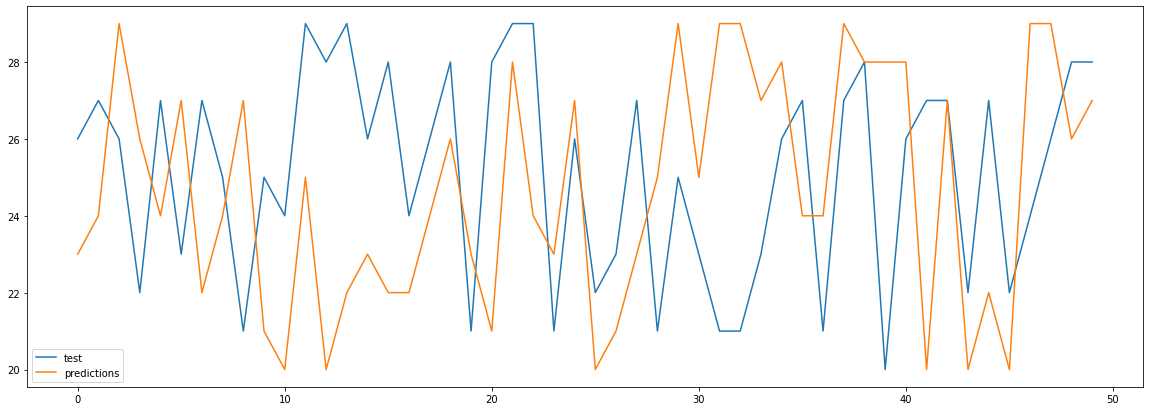

In [ ]:
dfMetricTest.plot(figsize=(20, 7))

In [ ]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [ ]:
mse(dfMetricTest['test'], dfMetricTest['predictions'])

17.02

# Checking seasonality

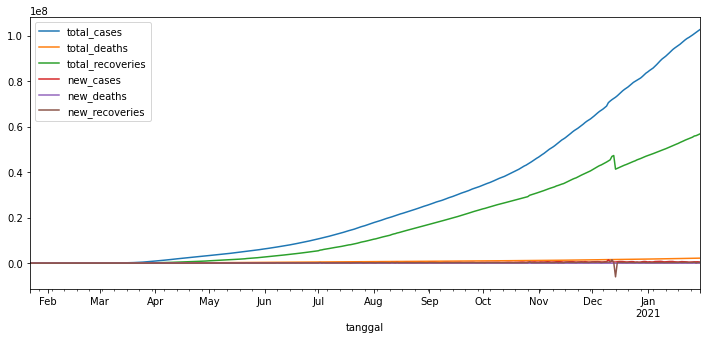

In [ ]:
dataset.plot()

In [ ]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

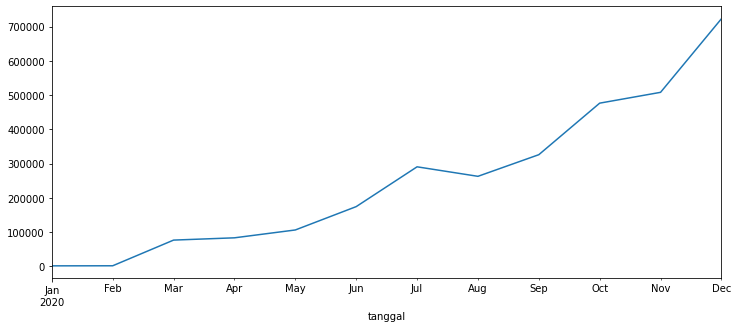

In [ ]:
datasetM = dataset.asfreq(freq='M')
datasetM['new_cases'].plot()

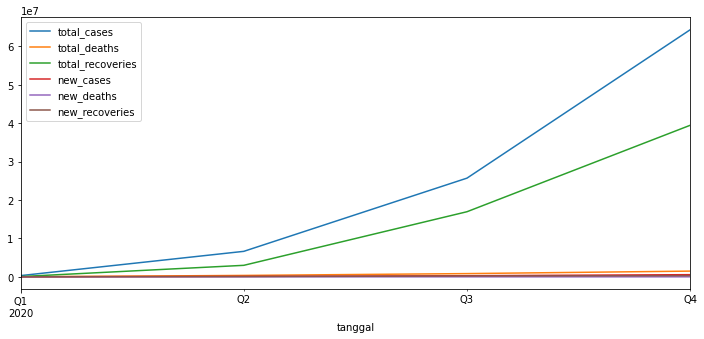

In [ ]:
datasetQ = datasetM.resample(rule='Q').mean()
datasetQ.plot();

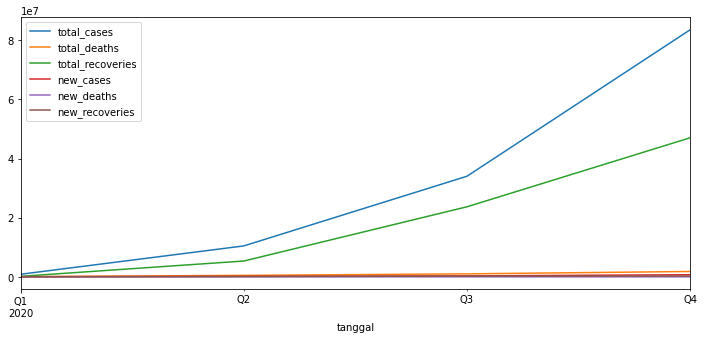

In [ ]:
datasetQ2 = dataset.asfreq(freq='Q')
datasetQ2.plot()

### AUTO ARIMA

In [ ]:
stepwise_fit = auto_arima(datasetCase, start_p=0, start_q=0, 
                          max_p=6, max_q=3,
                          seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9450.494, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9430.517, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9393.037, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9448.623, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9365.194, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9360.065, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9428.540, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9328.470, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9404.643, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9290.306, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9343.812, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=9269.478, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=9287.024, Time=0.27 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=9259.972, Time=0.76 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept

In [ ]:
print(stepwise_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  375
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -4621.036
Date:                Sun, 31 Jan 2021   AIC                           9258.071
Time:                        10:48:20   BIC                           9289.466
Sample:                             0   HQIC                          9270.536
                                - 375                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6357.4325   4601.901      1.381      0.167   -2662.128    1.54e+04
ar.L1         -0.6510      0.018    -35.880      0.000      -0.687      -0.615
ar.L2         -0.5352      0.034    -15.899      0.0

stepwise_fit = auto_arima(datasetCase, start_p=0, start_q=0, 
                          max_p=6, max_q=3,
                          seasonal=True, trace=True,
                          m=12)

stepwise_model = auto_arima(dataset['new_cases'], start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=0, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)